In [1]:
import os
# Change this to be the path of the tree_rag folder
os.chdir("/work/submit/mcgreivy/beauty-in-stats/tree_rag")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")  # Clean background with gridlines for easy readability
plt.rcParams.update({
    "font.size": 12,          # Default font size for labels and titles
    "axes.labelsize": 14,     # Font size for axes labels
    "axes.titlesize": 16,     # Font size for title
    "xtick.labelsize": 12,    # Font size for x-tick labels
    "ytick.labelsize": 12,    # Font size for y-tick labels
    "legend.fontsize": 8,    # Decreased font size for legend text
    "figure.figsize": (8, 6), # Size of the figure (width, height in inches)
    "lines.linewidth": 2,     # Default line width for plot lines
    "lines.markersize": 8,    # Marker size for plot markers
    "grid.alpha": 0.3,        # Transparency for grid lines
    "axes.grid": True,        # Show grid lines
    "axes.edgecolor": 'black', # Edge color of axes
    "axes.linewidth": 1,      # Thickness of the axes lines
    "savefig.dpi": 300,       # Higher DPI for publication-quality output
    "savefig.transparent": True,  # Transparent background for saving
    "figure.autolayout": True,  # Prevent overlapping labels and titles
    "figure.facecolor" : "white",
    "savefig.facecolor" : "white",
})

import pickle
import regex as re
import torch
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import time
import chromadb
from sentence_transformers import SentenceTransformer
import json

from paper_tree import PaperTree
import rag

import importlib
importlib.reload(rag)

FileNotFoundError: [Errno 2] No such file or directory: '/work/submit/mcgreivy/beauty-in-stats/tree_rag'

### Load the validation data

In [ ]:
headers = []
validation_data_dir = "./validation_data/jsons/"
split_tex_dir = "/work/submit/mcgreivy/paper_trees_cache/split_tex/"

for file in os.listdir(validation_data_dir):
    pattern = r"(.*).json"
    header = re.findall(pattern, file)[0]
    headers.append(header)

print(headers)

['1102.0206', '1109.0963', '1301.7084', '1402.6852', '1403.1339', '1404.0275', '1405.3219', '1406.2624', '1407.2222', '1408.5373', '1508.00788']


In [4]:
questions_to_answers = {}
questions_to_linenumbers = {}
for header in headers:
    questions_to_answers[header] = {}
    questions_to_linenumbers[header] = {}
    
    with open(split_tex_dir + f"{header}.tex", 'r', encoding='utf-8') as file:
        lines = file.readlines()

    with open(validation_data_dir + f'{header}.json', 'r') as file:
        q_to_line = json.load(file)
        
    for question in q_to_line:
        answers = []
        for start, end in q_to_line[question]:
            answer = re.sub("\s+", " ", "".join(lines[start - 1 : end]))
            answers.append(answer)
        questions_to_answers[header][question] = answers
        questions_to_linenumbers[header][question] = q_to_line[question]

### Load the paper tree

In [5]:
load_dir = "/work/submit/mcgreivy/paper_trees_cache/summarized_openai_paper_trees/"
filenames = list(filter(lambda str : (".pkl" in str[-4:]), os.listdir(load_dir)))

papers = {}
for filename in filenames:
    pattern = r"(.*).pkl"
    header = re.findall(pattern, filename)[0]
    if header not in headers:
        continue
    with open(load_dir + filename, "rb") as f:
        paper = pickle.load(f)
        papers[paper.title] = paper

## Evals for RAG performance

In [6]:
def generate_ngrams(text, n = 3):
    text = re.sub("\s+", " ", text)
    words = re.split(r"([.,;\{\}\(\)\s])", text)
    words = [word for word in words if len(word.strip()) > 0]
    ngrams = [" ".join(words[i:i + n]) for i in range(len(words) - n + 1)]
    return set(ngrams)

def overlap(str1, str2):
    str1 = generate_ngrams(str1)
    str2 = generate_ngrams(str2)
    return len(str1.intersection(str2)) / min(len(str1), len(str2))

def compute_overlap(answers, final_results):
    scores = [] 
    for label, chunk in final_results:
        for answer in answers:
            score = overlap(chunk, answer)
            if score < 0.25:
                score = 0
            scores.append(score)
    return sum(scores)

def evaluate_rag(rag, questions, n_results):
    headers = list(questions.keys())
    precisions, recalls, f1s = [], [], []
    for header in headers:
        filter_ids = [f"{header}.tex"]
        queries = list(questions[header].keys())
        for query in queries:
            answers = questions[header][query]
            if len(answers) == 0:
                continue
            results = rag.query(query, n_results=n_results, filter_ids=filter_ids)
            
            overlap = compute_overlap(answers, results)
            precision = overlap / len(results)
            recall = overlap / len(answers)
            
            precisions.append(precision)
            recalls.append(recall)
            f1s.append( (2 * precision * recall) / (precision + recall + 1e-9) )
    return np.array(precisions), np.array(recalls), np.array(f1s)

In [7]:
level_rag = rag.LevelSearchRAG(papers)
level_rerank_rag = rag.LevelSearchRerankRAG(papers)
base_rag = rag.BaseRAG(papers)
base_rerank_rag = rag.BaseRerankRAG(papers)

In [ ]:
import time
import numpy as np

n_results_range = np.arange(1, 7)

level_rerank_precision, level_rerank_recall, level_rerank_f1 = [], [], []
level_precision, level_recall, level_f1 = [], [], []
base_rerank_precision, base_rerank_recall, base_rerank_f1 = [], [], []
base_precision, base_recall, base_f1 = [], [], []

for n_results in n_results_range:
    n_results = int(n_results)
    print(n_results)
    precision, recall, f1 = evaluate_rag(level_rerank_rag, questions_to_answers, n_results)
    level_rerank_precision.append(precision)
    level_rerank_recall.append(recall)
    level_rerank_f1.append(f1)
    
    precision, recall, f1 = evaluate_rag(level_rag, questions_to_answers, n_results)
    level_precision.append(precision)
    level_recall.append(recall)
    level_f1.append(f1)
    
    precision, recall, f1 = evaluate_rag(base_rerank_rag, questions_to_answers, n_results)
    base_rerank_precision.append(precision)
    base_rerank_recall.append(recall)
    base_rerank_f1.append(f1)
    
    precision, recall, f1 = evaluate_rag(base_rag, questions_to_answers, n_results)
    base_precision.append(precision)
    base_recall.append(recall)
    base_f1.append(f1)

level_rerank_precision = np.array(level_rerank_precision)
level_rerank_recall = np.array(level_rerank_recall)
level_rerank_f1 = np.array(level_rerank_f1)

level_precision = np.array(level_precision)
level_recall = np.array(level_recall)
level_f1 = np.array(level_f1)

base_rerank_precision = np.array(base_rerank_precision)
base_rerank_recall = np.array(base_rerank_recall)
base_rerank_f1 = np.array(base_rerank_f1)

base_precision = np.array(base_precision)
base_recall = np.array(base_recall)
base_f1 = np.array(base_f1)

1


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


2


## Plot Precision, Recall, F1 Score

In [ ]:
level_rerank_precision

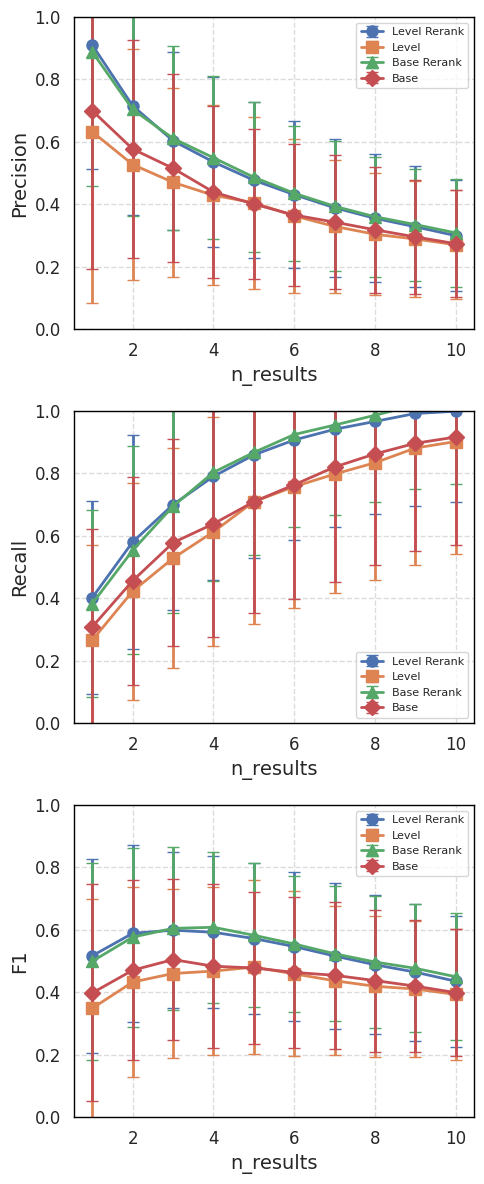

In [69]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 12))

level_rerank_precision_mean = np.mean(level_rerank_precision, axis=1)
level_rerank_precision_std = np.std(level_rerank_precision, axis=1)
level_precision_mean = np.mean(level_precision, axis=1)
level_precision_std = np.std(level_precision, axis=1)
base_rerank_precision_mean = np.mean(base_rerank_precision, axis=1)
base_rerank_precision_std = np.std(base_rerank_precision, axis=1)
base_precision_mean = np.mean(base_precision, axis=1)
base_precision_std = np.std(base_precision, axis=1)

level_rerank_recall_mean = np.mean(level_rerank_recall, axis=1)
level_rerank_recall_std = np.std(level_rerank_recall, axis=1)
level_recall_mean = np.mean(level_recall, axis=1)
level_recall_std = np.std(level_recall, axis=1)
base_rerank_recall_mean = np.mean(base_rerank_recall, axis=1)
base_rerank_recall_std = np.std(base_rerank_recall, axis=1)
base_recall_mean = np.mean(base_recall, axis=1)
base_recall_std = np.std(base_recall, axis=1)

level_rerank_f1_mean = np.mean(level_rerank_f1, axis=1)
level_rerank_f1_std = np.std(level_rerank_f1, axis=1)
level_f1_mean = np.mean(level_f1, axis=1)
level_f1_std = np.std(level_f1, axis=1)
base_rerank_f1_mean = np.mean(base_rerank_f1, axis=1)
base_rerank_f1_std = np.std(base_rerank_f1, axis=1)
base_f1_mean = np.mean(base_f1, axis=1)
base_f1_std = np.std(base_f1, axis=1)

axs[0].errorbar(n_results_range, level_rerank_precision_mean, yerr=level_rerank_precision_std, 
                label="Level Rerank", capsize=4, marker='o')
axs[0].errorbar(n_results_range, level_precision_mean, yerr=level_precision_std, 
                label="Level", capsize=4, marker='s')
axs[0].errorbar(n_results_range, base_rerank_precision_mean, yerr=base_rerank_precision_std, 
                label="Base Rerank", capsize=4, marker='^')
axs[0].errorbar(n_results_range, base_precision_mean, yerr=base_precision_std, 
                label="Base", capsize=4, marker='D')
axs[0].legend()
axs[0].set_ylabel("Precision")
axs[0].set_xlabel("n_results")
axs[0].set_ylim(0, 1)
axs[0].grid(True, linestyle='--', alpha=0.7)

axs[1].errorbar(n_results_range, level_rerank_recall_mean, yerr=level_rerank_recall_std, 
                label="Level Rerank", capsize=4, marker='o')
axs[1].errorbar(n_results_range, level_recall_mean, yerr=level_recall_std, 
                label="Level", capsize=4, marker='s')
axs[1].errorbar(n_results_range, base_rerank_recall_mean, yerr=base_rerank_recall_std, 
                label="Base Rerank", capsize=4, marker='^')
axs[1].errorbar(n_results_range, base_recall_mean, yerr=base_recall_std, 
                label="Base", capsize=4, marker='D')
axs[1].legend()
axs[1].set_ylabel("Recall")
axs[1].set_xlabel("n_results")
axs[1].set_ylim(0, 1)
axs[1].grid(True, linestyle='--', alpha=0.7)

axs[2].errorbar(n_results_range, level_rerank_f1_mean, yerr=level_rerank_f1_std, 
                label="Level Rerank", capsize=4, marker='o')
axs[2].errorbar(n_results_range, level_f1_mean, yerr=level_f1_std, 
                label="Level", capsize=4, marker='s')
axs[2].errorbar(n_results_range, base_rerank_f1_mean, yerr=base_rerank_f1_std, 
                label="Base Rerank", capsize=4, marker='^')
axs[2].errorbar(n_results_range, base_f1_mean, yerr=base_f1_std, 
                label="Base", capsize=4, marker='D')
axs[2].legend()
axs[2].set_ylabel("F1")
axs[2].set_xlabel("n_results")
axs[2].set_ylim(0, 1)
axs[2].grid(True, linestyle='--', alpha=0.7)

# Set the figure background to white
fig.patch.set_facecolor('white')

# Set background color for each subplot
for ax in axs:
    ax.set_facecolor('white')

plt.tight_layout()

plt.savefig("/work/submit/mcgreivy/beauty-in-stats/tree_rag/plots/precision_recall_f1_with_std.png", dpi=300, transparent=False)
plt.show()

In [73]:
id = '1405.3219'

questions = list(questions_to_answers[id].keys())
print(questions[5])

How does the analysis utilize simulated events to study detector response and background sources?


In [74]:
questions_to_answers[id][questions[5]]

['Simulated events are used to study the detector response to signal decays and to investigate potential sources of background. In the simulation, $pp$ collisions are generated using \\pythia~\\cite{Sjostrand:2006za} with a specific \\lhcb configuration~\\cite{LHCb-PROC-2010-056}. Decays of hadronic particles are described by \\evtgen~\\cite{Lange:2001uf}, in which final state radiation is generated using \\photos~\\cite{Golonka:2005pn}. The interaction of the generated particles with the detector and its response are implemented using the \\geant toolkit~\\cite{Allison:2006ve, *Agostinelli:2002hh} as described in Ref.~\\cite{LHCb-PROC-2011-006}. ',
 'The relative efficiencies are determined from samples of simulated events, generated with either a phase-space distribution for previously unobserved decay modes, or including known contributions from resonant structures. ',
 'To optimise the simulation-based selection, used only for the determination of the relative branching fraction of